In [26]:
# This notebook is the equivalent to read_and_xi.ipynb
# but it uses correlation measurements performed
# with Corrfunc.

In [27]:
from pathlib import Path # Handle paths more easily
import matplotlib.pyplot as plt # Make plots
import numpy as np 

import fitsio # Handle fits files
import sys # 
plt.style.use('tableau-colorblind10') # Change style to colorblind

In [28]:
# Import classes to read CoLoRe boxes and compute computations
# read abacus power spectra files in a similar way.
from CoLoRe_corrf_analysis.cf_helper import CFComputations, CFComputationsAbacus

In [29]:
rsd = False

# zmin and zmax as passed to corrfunc
zmin = 1.2
zmax = 1.4

# Read Model

In [30]:
from CoLoRe_corrf_analysis.read_colore import ComputeModelsCoLoRe

In [31]:
# The model to fit for Pks (or correlations) takes as an input a CoLoRe box
# the model will be generated matching the cosmology of the given input box.
colore_box = Path(
    "/global/cfs/cdirs/desicollab/users/cramirez/oxford_visit_v2/lightcone/v1/"
    "boxes/colore_box_exp_bias_1024_0_v1/results"
)

model = ComputeModelsCoLoRe(
    box_path=colore_box,
    source=1, # Important to also match the source for bias, etc...
    param_cfg_filename=colore_box.parent / "param.cfg", # Usually the code will try to find this file by reading the config, but it failis if it has been moved
    snapshot=False, # We are reading snapshots. This is only used to freeze bias evolution, etc...
    # smooth_factor=0, # For now we are going to ignore all smoothing factors
    # smooth_factor_rsd=0,
    # smooth_factor_cross=0,
    # smooth_factor_analysis=0,
    
)

z = model.get_zeff(zmin, zmax)

Text(0, 0.5, '$r^2 \\xi(r) \\, [Mpc^3 h^{-3}]$')

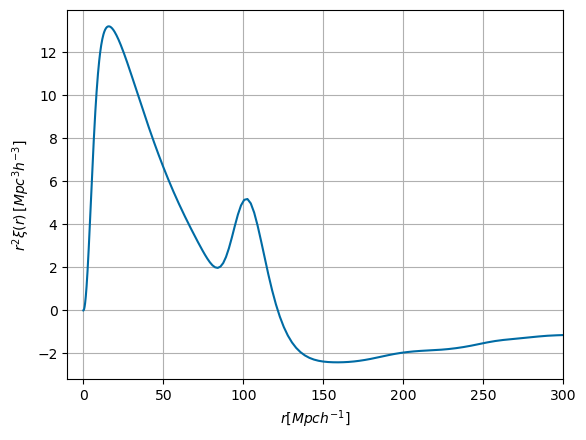

In [32]:
# Now a given model can be generated by using

xi = model.get_npole(0, z=2)

fig, ax = plt.subplots()

ax.plot(
    model.r,
    xi*model.r**2,
)
ax.grid()
ax.set_xlim(-10, 300)
ax.set_xlabel(r"$r [Mpc h^{-1}]$")
ax.set_ylabel(r"$r^2 \xi(r) \, [Mpc^3 h^{-3}]$")

## Read Corrf outputs

In [33]:
# If we want to perform a similar analysis as with Abacus,
# we need to look at multiple CoLoRe boxes with the same
# cosmology.
corrf_outputs_glob = Path(
    "/global/cfs/cdirs/desicollab/users/cramirez/oxford_visit_v2/lightcone/v1/boxes"
).glob(f"colore_box_exp_bias_*v1/Corrf/source_1no_rsd*/results")

# Create array to store the different measurements
colore_boxes = []
for result in corrf_outputs_glob:
    # In the case of abacus, one file contains only one tracer
    # With CoLoRe we can read multiple tracers.
    colore_boxes.append(CFComputations(
        results_path=result,
    ))


## Make fits

In [34]:
from CoLoRe_corrf_analysis.fitter import Fitter

In [35]:
# A fitter takes as input both the boxes we want to use to read the data
# and the model we want to fit

colore_fit = Fitter(
    boxes=colore_boxes,
    z=z,
    poles=[0,], # Multipoles to include in the fit (we are fitting only monopole now since norsd
    theory=model, 
    rsd=rsd,
    rmin={0: 10}, # k-min and k-max in the fit are defined per multipole.
    rmax={0: 140},
)

In [36]:
# Now we can perform the actual fit. It can take a while if the data
# for the CoLoRe box has not been computed previously

# We pass the free parameters to the fitter.
# the parameters that can be set free in the fitter are:
    # "bias",
    # "smooth_factor",
    # "smooth_factor_rsd",
    # "smooth_factor_cross",
    # "bias2",
    # "scale_factor",
    # "z",

colore_fit.run_fit(
    bias = dict(vary=True)
)
# The fitter already outputs the results, but they can be accessed at any time
# by getting the attribute .out -> colore_fit.out

# colore_fit.out

In [37]:
from CoLoRe_corrf_analysis.plot_methods import Plots

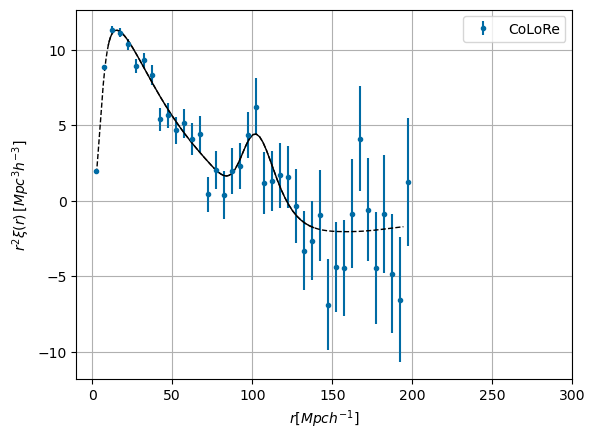

In [41]:
# Finally, we can plot the model with the data at the same time.

fig, ax = plt.subplots()

xis = np.array([box.compute_npole(n=0) for box in colore_boxes])

ax.errorbar(
    colore_boxes[0].savg, 
    xis.mean(axis=0)*colore_boxes[0].savg**2,
    yerr=xis.std(axis=0, ddof=1)*colore_boxes[0].savg**2 / np.sqrt(len(colore_boxes)),
    label="CoLoRe",
    fmt='.',
)


    
Plots.plot_best_fit(
    colore_fit,
    pole=0, # Multipole we want to plot.
    ax=ax, # We pass the axis where we want to plot.
    plot_args=dict(c='k', lw=1)
)
    

ax.grid()
ax.set_xlim(-10, 300)
ax.set_xlabel(r"$r [Mpc h^{-1}]$")
ax.set_ylabel(r"$r^2 \xi(r) \, [Mpc^3 h^{-3}]$")
ax.legend()